In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import os

In [2]:
#os.chdir('Parquet_files')

df_bikeshares = pd.read_parquet('Parquet_files/df_bikeshares.parquet')

df_bikeshares.head(10)

,Dates,Hour,Bikes share
0,2017-01-01,0,966
1,2017-01-01,1,910
2,2017-01-01,2,346
3,2017-01-01,3,286
4,2017-01-01,4,189
5,2017-01-01,5,151
6,2017-01-01,6,103
7,2017-01-01,7,78
8,2017-01-01,8,90
9,2017-01-01,9,162


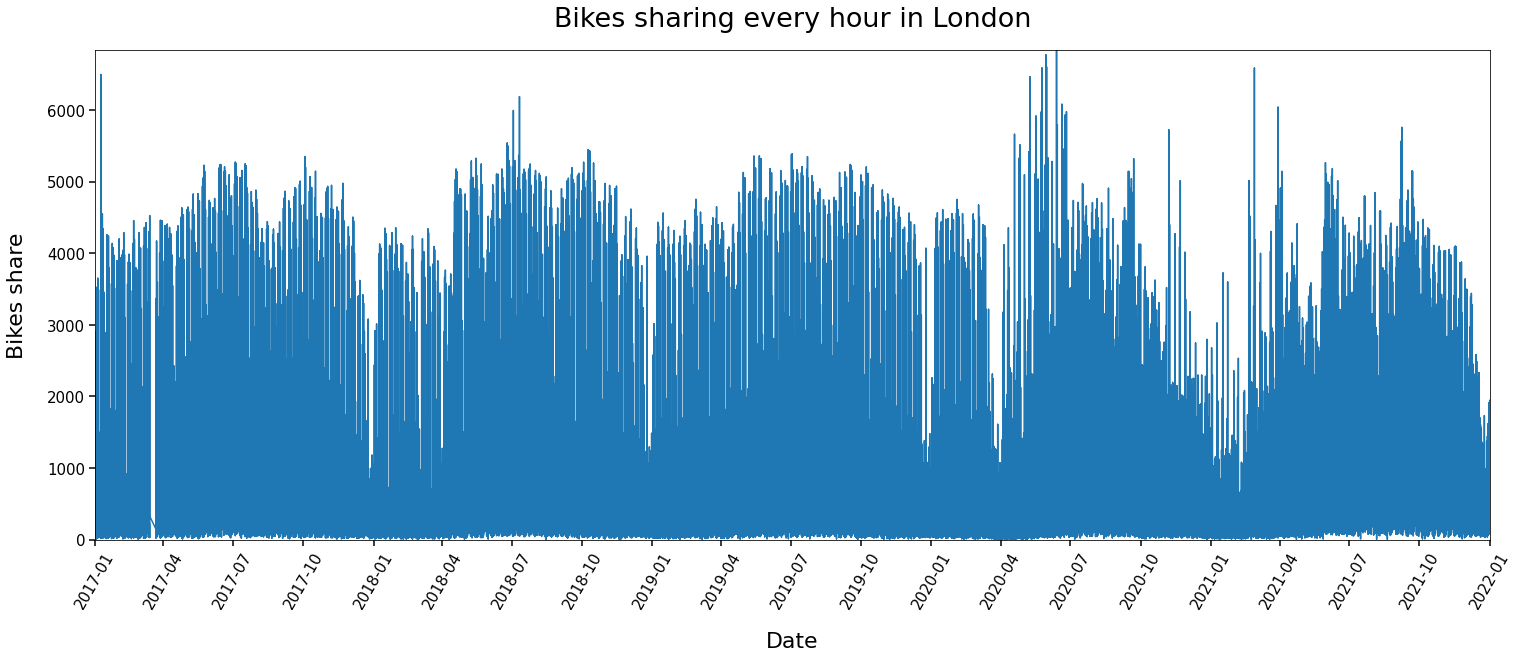

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize=(25, 9))

plt.plot(df_bikeshares['Dates'], df_bikeshares['Bikes share'])
plt.xlim((df_bikeshares['Dates'].min(), df_bikeshares['Dates'].max()))
plt.ylim((df_bikeshares['Bikes share'].min() - 1, df_bikeshares['Bikes share'].max() + 1))
plt.xlabel('Date', fontdict={'fontsize':22}, labelpad=20)
plt.ylabel('Bikes share', fontdict={'fontsize':22}, labelpad=20)
plt.tick_params(axis='x', width=1.5, length=6, labelsize=15, labelrotation=60)
plt.tick_params(axis='y', width=1.5, length=6, labelsize=15)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
plt.title('Bikes sharing every hour in London', fontsize=27, pad=24)

plt.show()

### For a specific date, from the `'Weather_data'` function I can get table containing info about weather

In [4]:
def Weather_data(date):
    ## URL leading directly to the site with table
    url_name = f'https://freemeteo.co.uk/weather/london/history/daily-history/?gid=2643743&station=1618&date={date}&language=english&country=united-kingdom'
    ## Parsing data and looking for table with class 'daily-history'
    html_file = requests.get(url_name).text
    table = BeautifulSoup(html_file, 'lxml').find('table', class_='daily-history').text
    return table

### Save the table as text files and make a Pandas Dataframe

In [5]:
def Create_text_file_and_DataFrame(date):
    weather_table = Weather_data(date)
    
    ## We make separate TXT file for every date we put inside this function
    with open(f"weather_data_{date}.txt", 'w', 1, 'utf8') as f:
        f.write(weather_table)

    df = open(f"weather_data_{date}.txt", "r", 1, 'utf8')
    lines = df.readlines()
    df.close()

    data_list = []
    # remove /n at the end of each line
    for index, line in enumerate(lines):
        lines[index] = line.strip()
        data_list.append(lines[index])

    return pd.DataFrame(data_list)

#### Looking at created DataFrame - for example date 2017-01-01

In [6]:
date = '2017-01-01'
df_weather = Create_text_file_and_DataFrame(date)

In [7]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       593 non-null    object
dtypes: object(1)
memory usage: 4.8+ KB


#### Let's look for regularities in the arrangement of the data

In [8]:
## First 40. indexes
df_weather[:40]

,0
0,
1,
2,
3,Time
4,Temperature
5,Relative Temperature
6,Wind
7,Wind Gust
8,Rel. humidity
9,Dew Point


In [9]:
## Last 30. indexes
df_weather.tail(30)

,0
563,4°C
564,1022.0mb
565,
566,Few Clouds at 340m
567,
568,
569,23:20
570,5°C
571,3°C
572,10°9 Km/h


#### There is a pattern in the positions of values and empty cells in this one column table (Series)

In [10]:
def series_to_dataframe():
    ## Start from rows with table header (future columns name)
    df = df_weather[3:13].reset_index(drop=True)
    ## 48 cyclical weather measurements (every 30 mins) - 10 positions/elements for each
    for i in range(0, 48):
        _ = df_weather[17+12*i:27+12*i].reset_index(drop=True)
        df = pd.concat([df, _], axis=1)
    return df

series_to_dataframe()

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Time,00:20,00:50,01:20,01:50,02:20,02:50,03:20,03:50,04:20,...,19:20,19:50,20:20,20:50,21:20,21:50,22:20,22:50,23:20,23:50
1,Temperature,8°C,7°C,7°C,7°C,7°C,7°C,7°C,7°C,7°C,...,5°C,5°C,5°C,5°C,5°C,5°C,5°C,5°C,5°C,5°C
2,Relative Temperature,5°C,5°C,5°C,5°C,4°C,4°C,4°C,5°C,5°C,...,2°C,2°C,2°C,2°C,2°C,2°C,2°C,2°C,3°C,2°C
3,Wind,230°17 Km/h,230°11 Km/h,230°9 Km/h,240°11 Km/h,240°17 Km/h,210°15 Km/h,220°15 Km/h,220°13 Km/h,220°13 Km/h,...,30°15 Km/h,30°15 Km/h,20°13 Km/h,20°15 Km/h,10°17 Km/h,10°11 Km/h,10°13 Km/h,10°11 Km/h,10°9 Km/h,10°11 Km/h
4,Wind Gust,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,...,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A
5,Rel. humidity,82%,87%,87%,87%,87%,87%,87%,87%,81%,...,93%,93%,93%,93%,93%,93%,93%,93%,93%,87%
6,Dew Point,5°C,5°C,5°C,5°C,5°C,5°C,5°C,5°C,4°C,...,4°C,4°C,4°C,4°C,4°C,4°C,4°C,4°C,4°C,3°C
7,Pressure,1023.0mb,1023.0mb,1022.0mb,1022.0mb,1021.0mb,1021.0mb,1020.0mb,1020.0mb,1019.0mb,...,1020.0mb,1020.0mb,1021.0mb,1021.0mb,1021.0mb,1022.0mb,1022.0mb,1022.0mb,1022.0mb,1023.0mb
8,Icon,,,,,,,,,,...,,,,,,,,,,
9,DescriptionDetails,"Scattered Clouds at 400m, Broken Clouds at 1200m",Few Clouds at 1200m,Broken Clouds at 1300m,Broken Clouds at 1200m,Cloudy at 980m,"Few Clouds at 340m, Scattered Clouds at 980m",Broken Clouds at 940m,Broken Clouds at 980m,Broken Clouds at 1000m Light Rain,...,"Broken Clouds at 370m, Cloudy at 1200m Light Rain","Broken Clouds at 370m, Broken Clouds at 670m, ...","Few Clouds at 580m, Broken Clouds at 760m, Clo...","Broken Clouds at 270m, Broken Clouds at 400m, ...","Scattered Clouds at 300m, Broken Clouds at 670...","Few Clouds at 400m, Scattered Clouds at 910m, ...","Few Clouds at 850m, Broken Clouds at 1300m",Few Clouds at 340m,,


### We need only `'Time'`, `'Temperature'`, `'Relative Temperature'`, `'Wind'`, `'Rel. humidity'` and `'DescriptionDetails'` columns from all dataset.

In [11]:
def Reshaping_dataframe():
    ## Remove useless data and take care of properly indexing
    _ = series_to_dataframe().drop([4,6,7,8]).reset_index(drop=True)
    ## Final shape of dataframe with reindexing
    return _.T.reset_index(drop=True)


def Columns_name_change():
    df = Reshaping_dataframe()

    ## Dictionary for change name of Dataframe columns
    new_name = {i:df.iloc[0, i] for i in range(0, df.shape[1])}
    df = df.rename(columns=new_name)
    
    ## Clean mess after renaming columns name
    return df.drop([0], axis='index').dropna(how='all').reset_index(drop=True)

In [12]:
## Checking results
Columns_name_change().head()

,Time,Temperature,Relative Temperature,Wind,Rel. humidity,DescriptionDetails
0,00:20,8°C,5°C,230°17 Km/h,82%,"Scattered Clouds at 400m, Broken Clouds at 1200m"
1,00:50,7°C,5°C,230°11 Km/h,87%,Few Clouds at 1200m
2,01:20,7°C,5°C,230°9 Km/h,87%,Broken Clouds at 1300m
3,01:50,7°C,5°C,240°11 Km/h,87%,Broken Clouds at 1200m
4,02:20,7°C,4°C,240°17 Km/h,87%,Cloudy at 980m


### It is necessary to clean the Dataframe column - change time to full hours, remove units and fill empty cells in `'DescriptionDetails'` column

In [13]:
def Time_column_change():
    df = Columns_name_change()
    ## Take only full hour with 50 minutes (xx:50) and reset index
    _ = df[df['Time'].str.contains(':50')].reset_index(drop=True)
    # Leave only numbers of hour in column 'Time' and change its name into 'Hour':
    return _.replace({'Time': r':.+$'}, {'Time': ''}, regex=True).rename(columns={'Time': 'Hour'})
    

def Remaining_columns_change():
    df = Time_column_change()
    # Leave only values in columns: 'Temperature', 'Relative Temperature', 'Rel. humidity', 'Wind'
    df = df.replace(to_replace=r'\D+$', value='', regex=True)
    df = df.replace({'Wind': r'.+\D+'}, {'Wind': ''}, regex=True)

    # Empty cells in 'DescriptionDetails' column will be changed into 'Clearly' value:
    df = df.replace({'DescriptionDetails': ''}, {'DescriptionDetails': 'Clearly'}, regex=False)
    
    return df


df_weather = Remaining_columns_change()

### Replace strings by numbers in 'DescriptionDetails' column

In [14]:
# "DescriptionDetails" categories:
weather_cats = {'Clear': 1,
                'Mostly Clear': 1,
                'Scattered Clouds': 2,
                'Few Clouds': 2,
                'Broken Clouds': 3,
                'Cloudy': 4,
                'Rain': 7,
                'Light Rain Shower': 7,
                'Light Rain': 7,
                'Rain with Thunderstorm': 10,
                'Snowfall': 26,
                'Freezing Fog': 94}

for i in ['\Wat.\d+m\W', '\Wat.\d+']:
    df_weather['DescriptionDetails'] = df_weather['DescriptionDetails'].replace(to_replace=rf"{i}", value='', regex=True)

df_weather['DescriptionDetails'] = df_weather['DescriptionDetails'].replace(weather_cats, regex=True)

In [15]:
df_weather.head()

,Hour,Temperature,Relative Temperature,Wind,Rel. humidity,DescriptionDetails
0,00,7,5,11,87,2
1,01,7,5,11,87,3
2,02,7,4,15,87,2
3,03,7,5,13,87,3
4,04,7,5,13,81,2


In [16]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Hour                  24 non-null     object
 1   Temperature           24 non-null     object
 2   Relative Temperature  24 non-null     object
 3   Wind                  24 non-null     object
 4   Rel. humidity         24 non-null     object
 5   DescriptionDetails    24 non-null     int64 
dtypes: int64(1), object(5)
memory usage: 1.2+ KB


In [17]:
df_weather = df_weather.astype('int8')

## Final Dataframe is saving as parquet file which name has format 'date_weather_info' (for example '2017-01-01_weather_info.parquet')

In [18]:
df_weather.to_parquet(f'Parquet_files/{date}_weather_info.parquet', compression='snappy')